[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/PolarGeospatialCenter/pgc-code-tutorials/blob/main/dynamic_stac_api/stac_api_demo_workflow.ipynb)

# PGC Dynamic STAC API Tutorial
## How to query and fetch PGC Digital Elevation Models (DEMs) with python

The [Polar Geospatial Center](https://www.pgc.umn.edu) produces DEMs from high resolution satellite imagery and makes them publicly available for the polar regions through the [ArcticDEM](https://www.pgc.umn.edu/data/arcticdem/) and [Reference Elevation Model of Antarctica (REMA)](https://www.pgc.umn.edu/data/rema/) products, as well as a subset of the [EarthDEM](https://www.pgc.umn.edu/data/earthdem/) data for the area around the Great Lakes region that is publicly available. These are continent-scale, high resolution (2m), repeat coverage elevation models published as time-stamped DEM Strips and (mostly) seamless Mosaics. You can find out more about [this elevation data on our website](https://www.pgc.umn.edu/data/elevation/). 

There are several methods for viewing and downloading the data, but this notebook will focus on how to leverage the dynamic STAC API to query the datasets and retrieve the data you want within a python environment to integrate with geospatial workflows. The data is hosted on the AWS Registry of Open Data ([ArcticDEM](https://registry.opendata.aws/pgc-arcticdem/) and [REMA](https://registry.opendata.aws/pgc-rema/)), where you can browse a static version of the STAC catalog to preview the data or find the link to the dynamic STAC API that we will be demonstrating here. 

## In this tutorial we will demonstrate how to:
1. Access the STAC API endpoint
2. Review available data collections
3. Query the API with spatial and temporal constraints
4. Add the returned items to geopandas and xarray data structures for integration with other workflows

## What is STAC?
STAC - [Spatio Temporal Asset Catalog](https://stacspec.org/en) is a standard for organizing geospatial data for convenient access. Essentially, it is a set of GeoJSON-formatted metadata describing location and time for geospatial information, with links to the actual data, organized within sets of Catalogs and Collections. We will look at each of these in turn using python tools to query the API. 

The developers of the STAC standard provide [additional tutorials](https://stacspec.org/en/tutorials/) for leveraging the STAC APIs, including some [python tutorials](https://stacspec.org/en/tutorials/1-read-stac-python/) for reading data from a STAC Catalog using the pystac library and for accessing [Sentinel-2 data from AWS](https://stacspec.org/en/tutorials/access-sentinel-2-data-aws/) and [Landsat data from Microsoft Planetary Computer](https://stacspec.org/en/tutorials/reading-stac-planetary-computer/).

## Importing Libraries for STAC API
The first step is to import the necessary pyton libraries for interacting with the API. We will be using the pystac_client library to connect to the PGC STAC Catalog through the API url: `https://stac.pgc.umn.edu/api/v1/`

We will build a query for the STAC API based on geographic location in two ways: frist, by zooming to our area of interest in a webmap within the notebook and second, by defining an area from a shapefile.

Once the API returns the list of DEM items, we will load the metadata into a geopandas dataframe to look at the attributes and finally into an xarray dataset where we can visualize the data and pass it on to any downstream data analysis/processing.

Detailed documentation for the libraries used in this tutorial and additional example workflows can be found at their respective websites:

 - [pystac_client](https://pystac-client.readthedocs.io/en/stable/) - interact with the STAC API
 - [ipyleaflet](https://ipyleaflet.readthedocs.io/en/latest/index.html) - extension of the leaflet mapping library to make interactive web maps within the jupyter notebook for spatial querying
 - [stackstac](https://stackstac.readthedocs.io/en/latest/index.html#) - read STAC API datasets into xarray data structures
 - [xarray](https://docs.xarray.dev/en/stable/) - work with multidimensional arrays, lazy loading, and parallel processing - great for geospatial raster data
 - [geopandas](https://geopandas.org/en/stable/index.html) - read item-level metadata and perform attribute queries on item footprints


#### Running this notebook via Google Colab
To run this interactive notebook in the browser, click the `Open in Colab` button at the top of this page. This will open the notebook in Google Colab, a browser-based environment for running notebooks. You will have to run the first code cell to install the necessary packages prior to importing them. You will likely be prompted to authorize the running of the notebook for the first cell since it was not published by Google directly.

#### Running this notebook locally
##### Creating the evnironment to run this notebook
To import the libraries needed to run this notebook, you will need a software environment with them installed. We recommend using the conda (or mamba) environment manager. To build the environment, first install conda or mamba and then run the following command, with the `-f` argument pointing at the `stac_environment.yml` file included next to this notebook in the github repository:

```conda env create -f stac_environment.yml```

##### Launching the notebook
Once you have created the conda environment, you can activate the environment in your conda shell with `conda activate pgc-stac-environment`, then run `jupyter notebook`, and navigate to the `stac_api_demo_workflow.ipynb` to launch the notebook. NOTE: You will not need to run the first cell `pip install ...` if you are running the ntoebook locally with the `pgc-stac-environment` 

In [ ]:
# Only run this cell when using Google Colab for the notebook
%pip install pystac-client ipyleaflet stackstac xarray geopandas[all];

In [1]:
# access the STAC API and build a search query
import pystac_client
import ipyleaflet

# read the data for analysis and visualization
import stackstac
import xarray as xr
import geopandas as gpd
import pandas as pd
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt

# print figures within the jupyter notebook
%matplotlib inline

### Catalogs

The top level organization of the PGC STAC is the Catalog. This top level contains information about the API itself and the data contained within it, kind of like the top level of a file directory with lots of content organized within. We will load the catalog and take a look at the contents using built in methods from the `pystac_client` library.

Since we are only reading metadata, this data exploration happens almost immediately without having to load any of the actual data.


In [2]:
# access the PGC Data Catalog API
cat = pystac_client.Client.open("https://stac.pgc.umn.edu/api/v1/")
print("Catalog Title: {}".format(cat.title))

# view the components of the Catalog
cat

Catalog Title: PGC Data Catalog


<Client id=pgc-data-stac>

### Collections

Next, let's look at the collections available within the PGC Catalog. These represent the different products available through the API, broken out by region (ArcticDEM, REMA, and EarthDEM) and product type (DEM Strips and DEM Mosaics) at different resolutions.

In [3]:
# see the available collections in the catalog
for collection in cat.get_collections():
    print(collection)

<CollectionClient id=arcticdem-mosaics-v3.0-2m>
<CollectionClient id=arcticdem-mosaics-v3.0-10m>
<CollectionClient id=arcticdem-mosaics-v3.0-32m>
<CollectionClient id=arcticdem-mosaics-v4.1-2m>
<CollectionClient id=arcticdem-mosaics-v4.1-10m>
<CollectionClient id=arcticdem-mosaics-v4.1-32m>
<CollectionClient id=arcticdem-strips-s2s041-2m>
<CollectionClient id=earthdem-strips-s2s041-2m>
<CollectionClient id=rema-mosaics-v2.0-2m>
<CollectionClient id=rema-mosaics-v2.0-10m>
<CollectionClient id=rema-mosaics-v2.0-32m>
<CollectionClient id=rema-strips-s2s041-2m>


In [4]:
# Filter the collections to view just the REMA datasets
collection_search = cat.collection_search(
    q="rema",
)

for result in collection_search.collections():
    print(result.id, f"{result.description}", sep="\n")
    print("\n")

rema-mosaics-v2.0-2m
REMA DEM mosaics, version 2.0, 2m resolution


rema-mosaics-v2.0-10m
REMA DEM mosaics, version 2.0, 10m resolution


rema-mosaics-v2.0-32m
REMA DEM mosaics, version 2.0, 32m resolution


rema-strips-s2s041-2m
REMA time-stamped strip DEMs, s2s version 4.1, 2m resolution


### Strip DEMs

Looking at the metadata for the REMA 2m Strip DEMs collection, we can see what data layers are available under `item_assets` and some other information about spatial and temporal extent that get used when querying for specific strips. The `links` information gets called when we want to actually load data from AWS later in the workflow.

Once we start loading actual data, we will want to specify which of the asset layers we want to use. There is, of course, a 2m `DEM` asset with the actual elevation values, but we can also leverage the `mask` to remove any unusable data in the DEM and two 10m `hillshade` layers (one with the mask already applieed) that are useful for quicker/more intuitive visualizations without loading the full resolution `DEM`. 

In [5]:
# get the REMA strips collection
rema_strips_col = cat.get_collection("rema-strips-s2s041-2m")
rema_strips_col

<CollectionClient id=rema-strips-s2s041-2m>

### DEM Mosaics

Now we can take a look at the metadata in the DEM Mosaics collection. Here we'll look at the 32m REMA Mosaics collection. These data come in tiled rasters covering 100km by 100km areas. When combining them, we arrange them next to each other instead of stacking them like we would with the Strip DEMs. 

You will notice that the `item_assets` are different than the strip DEMs collection. Again we see the `DEM` and `Hillshade` layers, but there is no mask necessary for the mosaics since bad data was removed during the processing, resulting in a mostly seamless elevation surface. Since the mosaics are a combination of data from all the valid DEM strips over an area, each pixel can come from a different source DEM with a different capture date, which gets recorded in the `mindate` and `maxdate` layers for each mosaic tile. 

In [6]:
# get the REMA 32m Mosaics collection metadata
rema_32m_mosaic_col = cat.get_collection("rema-mosaics-v2.0-32m")
rema_32m_mosaic_col

<CollectionClient id=rema-mosaics-v2.0-32m>

### Items
Finally, we have the items. Each individual data file--in this case a strip DEM or mosaic tile--is represented as a STAC Item. These Items have all the attributes of the DEM files along with links for accessing the data from the cloud directly, as we will show here, or downloading it to use locally. 

To access the items, we will walk through a typical workflow to query one of the Collections (REMA 2m DEM Strips), filtering by location, time, and data quality.

There are multiple ways to create a bounding box to query the collection for data within your Area of Interest (AOI). Here we demonstrate how to use an interactive leaflet map within the notebook to zooom to an area and extract the bounding box coordinate to pass to the API. Zoom/pan the map to the region for which you want the data, then run the code cell below the map to extract the bounding box of the map extent. Or, if you have a shapefile of the AOI, you can extract the bounding box using geopandas. Finally, if you already know the bounding box for your AOI, you can skip the interactive map and update the coordinates in the `bbox` variable with values of latitude and longitude. We'll use the map to identify an AOI near the Larsen A Ice Shelf along the Antarctic Peninsula. Caution: loading too much 2m strip data can crash a Jupyter notebook kernel, but we can look at a lot of the metadata without loading any of the actual data.

One note: the default projection for the leaflet map is Web Mercator, which does not work well for areas near the poles, but polar projections are supported.

In [80]:
# create a leaflet map widget to find an AOI for the spatial query of the STAC API
m = ipyleaflet.Map(scroll_wheel_zoom=True)
m.center = -65.1, -60.2
m.zoom = 9
m.layout.height = "600px"
m.layout.width = "1000px"
m

Map(center=[-65.1, -60.2], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_o…

In [66]:
# zoom and pan to a location on the map to use for your bounding box
# TIP: running the query at the default zoom level of 7 on the map will return a LOT of records (which is fine since it is only metadata!)
# For a more manageable amount of data for manaul review, we suggest zooming in to a smaller area on the map
bbox = (m.west, m.south, m.east, m.north)
bbox

(-61.70745849609376,
 -65.44456768370164,
 -58.69445800781251,
 -64.75070395955947)

In [67]:
# OR extract the bounding box from a vector file (geojson, shapefile, etc) with geopandas

aoi_shp_fp = "https://raw.githubusercontent.com/PolarGeospatialCenter/pgc-code-tutorials/main/dynamic_stac_api/demo_data/demo_aoi_larsen_a_ice_shelf.geojson"
aoi_gdf = gpd.read_file(aoi_shp_fp)
aoi_bbox = aoi_gdf.total_bounds
print(aoi_bbox)

[-61.25390699 -65.32412875 -59.22577797 -64.82460726]


#### Run the search query for items within your bbox

Now we can perform the actual query to the API to return the Strip DEM items within our bounding box. We will also add a query parameter for `datetime` to restrict the results to a single year. When the items for that query are returned, we can bring them into a geopandas dataframe to ivnestigate further and subset the outputs with more specific attribute queries to the set we want to use for analysis. Since all of this is only working with metadata, we don't have to load any of the actual data yet and the query operations happen immediately. 

In [68]:
# build the API query for the items within out bounding box and date range
search = cat.search(
    collections = ["rema-strips-s2s041-2m"],
    bbox=bbox,
    datetime="2022-01-01/2023-12-31"
)

In [69]:
# fetch the items that fit our search parameters
items = list(search.items())
print(len(items))

65


#### Review item properties with STAC metadata

Let's take a look at a sample strip DEM item that was returned from the query. First, we can see all the associated metadata. By expanding the `properties` section (and printing it all out in the cell below) we can see the individual attributes of the strip DEM. Once we build the geopandas dataframe, we can use those properties to further subset the data based on things like data quality.

In [70]:
items[4]

<Item id=SETSM_s2s041_WV01_20230805_10200100DB043A00_10200100DD5FE400_2m_seg1>

In [71]:
items[4].properties

{'gsd': 2.0,
 'title': 'SETSM_s2s041_WV01_20230805_10200100DB043A00_10200100DD5FE400_2m_seg1',
 'created': '2024-02-03T14:23:22Z',
 'license': 'CC-BY-4.0',
 'pgc:rmse': -9999,
 'proj:code': 'EPSG:3031',
 'published': '2024-06-18T19:48:45Z',
 'pgc:is_lsf': False,
 'proj:shape': [36755, 55962],
 'description': 'Digital surface models from photogrammetric elevation extraction using the SETSM algorithm.  The DEM strips are a time-stamped product suited to time-series analysis.',
 'instruments': ['WV01', 'WV01'],
 'pgc:geocell': 's65w062',
 'end_datetime': '2023-08-05T16:22:56Z',
 'pgc:pairname': 'WV01_20230805_10200100DB043A00_10200100DD5FE400',
 'constellation': 'maxar',
 'pgc:image_ids': ['10200100DB043A00', '10200100DD5FE400'],
 'pgc:is_xtrack': False,
 'proj:geometry': {'type': 'Polygon',
  'coordinates': [[[-2522370.0, 1322668.0],
    [-2410446.0, 1322668.0],
    [-2410446.0, 1396178.0],
    [-2522370.0, 1396178.0],
    [-2522370.0, 1322668.0]]]},
 'pgc:stripdemid': 'WV01_20230805_102

#### Load items into geopandas dataframe and refine your data query

Now we can load the items returned from the API search into a geopandas dataframe in order to further subset the data to what we want to use. First we will just look at the first five records and explore what the metadata includes. Then we can query out records that have noisy/cloudy data in them and remove corsstrack DEMs (created from "incidental stereo" pairs instead of imagery collected on a single satellite pass). Once we have our final set of data, we can map the footprints to see the data coverage and finally load some data to visualize. 

In [72]:
# load the items into a geopandas dataframe and look at the first five records
items_gdf = gpd.GeoDataFrame.from_features(search.item_collection().to_dict(), crs="epsg:4326").to_crs(3031)
items_gdf.head(5)

,geometry,gsd,title,created,license,pgc:rmse,proj:code,published,pgc:is_lsf,proj:shape,description,instruments,pgc:geocell,end_datetime,pgc:pairname,constellation,pgc:image_ids,pgc:is_xtrack,proj:geometry,pgc:stripdemid,proj:transform,start_datetime,pgc:s2s_version,pgc:avg_sun_elevs,pgc:setsm_version,pgc:cloud_area_sqkm,pgc:valid_area_sqkm,pgc:water_area_sqkm,pgc:cloud_area_percent,pgc:valid_area_percent,pgc:water_area_percent,pgc:avg_convergence_angle,pgc:masked_matchtag_density,pgc:valid_area_matchtag_density,pgc:avg_expected_height_accuracy,datetime
0,"MULTIPOLYGON Z (((-2403014 1370554 0, -2395390...",2.0,SETSM_s2s041_WV01_20230913_10200100DEA87100_10...,2023-12-21T19:19:48Z,CC-BY-4.0,-9999,EPSG:3031,2024-06-18T19:48:54Z,False,"[14869, 14607]",Digital surface models from photogrammetric el...,"[WV01, WV01]",s66w061,2023-09-13T16:04:58Z,WV01_20230913_10200100DEA87100_10200100DFDC4600,maxar,"[10200100DEA87100, 10200100DFDC4600]",False,"{'type': 'Polygon', 'coordinates': [[[-2403070...",WV01_20230913_10200100DEA87100_10200100DFDC460...,"[2.0, 0.0, -2403070.0, 0.0, -2.0, 1390016.0, 0...",2023-09-13T16:04:17Z,4.1,"[21.333333, 21.366666]",SETSM 4.3.15,15.571744,464.875240,0.000000,0.032411,0.967589,0.000000,31.086218,0.965397,0.997735,1.271017,None
1,"MULTIPOLYGON Z (((-2383740 1376510 0, -2390396...",2.0,SETSM_s2s041_W1W2_20230913_10200100DFDC4600_10...,2023-12-09T23:45:48Z,CC-BY-4.0,-9999,EPSG:3031,2024-06-18T19:48:54Z,False,"[7754, 9517]",Digital surface models from photogrammetric el...,"[W1W2, W1W2]",s66w060,2023-09-13T16:04:17Z,W1W2_20230913_10200100DFDC4600_10300100EDCA9000,maxar,"[10200100DFDC4600, 10300100EDCA9000]",True,"{'type': 'Polygon', 'coordinates': [[[-2392372...",W1W2_20230913_10200100DFDC4600_10300100EDCA900...,"[2.0, 0.0, -2392372.0, 0.0, -2.0, 1388508.0, 0...",2023-09-13T13:41:38Z,4.1,"[21.333333, 17.1]",SETSM 4.3.15,0.359552,144.418278,0.049088,0.002483,0.997178,0.000339,51.455837,0.986690,0.989482,0.750000,None
2,"MULTIPOLYGON Z (((-2429788 1305248 0, -2459276...",2.0,SETSM_s2s041_WV01_20230808_10200100DD5F8C00_10...,2024-02-03T14:20:45Z,CC-BY-4.0,-9999,EPSG:3031,2024-06-18T19:48:45Z,False,"[22570, 30221]",Digital surface models from photogrammetric el...,"[WV01, WV01]",s65w062,2023-08-08T16:51:33Z,WV01_20230808_10200100DD5F8C00_10200100DEE83800,maxar,"[10200100DD5F8C00, 10200100DEE83800]",False,"{'type': 'Polygon', 'coordinates': [[[-2478650...",WV01_20230808_10200100DD5F8C00_10200100DEE8380...,"[2.0, 0.0, -2478650.0, 0.0, -2.0, 1350386.0, 0...",2023-08-08T16:50:45Z,4.1,"[8.928571, 9.0]",SETSM 4.3.15,493.808208,628.262580,168.700088,0.398135,0.506540,0.136015,35.125297,0.464549,0.917103,1.117017,None
3,"MULTIPOLYGON Z (((-2437556 1309806 0, -2458928...",2.0,SETSM_s2s041_WV01_20230805_10200100DD25DA00_10...,2024-02-03T14:16:43Z,CC-BY-4.0,-9999,EPSG:3031,2024-06-18T19:48:45Z,False,"[17747, 19902]",Digital surface models from photogrammetric el...,"[WV01, WV01]",s65w062,2023-08-05T16:23:18Z,WV01_20230805_10200100DD25DA00_10200100DDB0D200,maxar,"[10200100DD25DA00, 10200100DDB0D200]",False,"{'type': 'Polygon', 'coordinates': [[[-2459328...",WV01_20230805_10200100DD25DA00_10200100DDB0D20...,"[2.0, 0.0, -2459328.0, 0.0, -2.0, 1340590.0, 0...",2023-08-05T16:22:14Z,4.1,"[8.38, 8.32]",SETSM 4.3.15,131.585128,493.046748,140.293012,0.175854,0.658920,0.187491,49.396898,0.615966,0.934813,0.768649,None
4,"MULTIPOLYGON Z (((-2506380 1369772 0, -2522322...",2.0,SETSM_s2s041_WV01_20230805_10200100DB043A00_10...,2024-02-03T14:23:22Z,CC-BY-4.0,-9999,EPSG:3031,2024-06-18T19:48:45Z,False,"[36755, 55962]",Digital surface models from photogrammetric el...,"[WV01, WV01]",s65w062,2023-08-05T16:22:56Z,WV01_20230805_10200100DB043A00_10200100DD5FE400,maxar,"[10200100DB043A00, 10200100DD5FE400]",False,"{'type': 'Polygon', 'coordinates': [[[-2522370...",WV01_20230805_10200100DB043A00_10200100DD5FE40...,"[2.0, 0.0, -2522370.0, 0.0, -2.0, 1396178.0, 0...",2023-08-05T16:21:50Z,4.1,"[8.65, 8.63125]",SETSM 4.3.15,949.077064,1168.591768,278.

In [73]:
# query geodataframe based on DEM attributes - we want intrack DEM strips with less than 40% cloudy pixels
subset_items_gdf = items_gdf[(items_gdf['pgc:is_xtrack'] == False) & (items_gdf['pgc:cloud_area_percent'] < 0.5)]

print(len(subset_items_gdf))

38


In [74]:
# plot the footprints of the subset geodataframe

# x = subset_items_gdf.plot(figsize=(10, 10), alpha=0.5, edgecolor="k")
subset_items_gdf.explore(tooltip=["pgc:pairname", "start_datetime", "pgc:cloud_area_percent","pgc:water_area_percent","pgc:valid_area_percent"])

Now we can use the same process to fetch some DEM mosaic tiles. We will use the same bounding box but our search will not return as many mosaic tiles because they do not overlap like the Strip DEMs do. We will look at the geopandas dataframe to examine the mosaic properties, but we won't need to perform an attribute query since the data has alrady been through rigorous Quality Control during production. We can go straight to visualizing geographic extent and then subset the tiles over the center of our AOI since the bbox intersects with the corners of a few neighboring tiles that we won't actually need.


In [75]:
# Build search query with the 32m Mosaic collection and bbox from above
mosaic_search = cat.search(
    collections = ["rema-mosaics-v2.0-32m"],
    bbox=bbox
)

# return the list of items 
mosaic_items = list(mosaic_search.items())
print(len(mosaic_items))

# convert items to geodataframe
mosaic_items_gdf = gpd.GeoDataFrame.from_features(mosaic_search.item_collection().to_dict(), crs="epsg:4326").to_crs(3031)
mosaic_items_gdf

5


,geometry,gsd,title,created,license,pgc:tile,proj:code,published,proj:shape,description,end_datetime,constellation,pgc:supertile,proj:geometry,proj:transform,start_datetime,pgc:pairname_ids,pgc:num_components,pgc:release_version,datetime
0,"MULTIPOLYGON Z (((-2500096 1400096 0, -2399904...",32.0,44_06_32m_v2.0,2022-08-08T01:22:19Z,CC-BY-4.0,44_06,EPSG:3031,2022-08-24T20:14:37Z,"[3131, 3131]",Digital surface model mosaic from photogrammet...,2020-09-05T00:00:00Z,maxar,44_06,"{'type': 'Polygon', 'coordinates': [[[-2500096...","[32.0, 0.0, -2500096.0, 0.0, -32.0, 1400096.0,...",2011-03-12T00:00:00Z,[W1W1_20120220_10200100193C9500_10200100198973...,207,2.0,None
1,"MULTIPOLYGON Z (((-2400096 1400096 0, -2299904...",32.0,44_07_32m_v2.0,2022-08-08T01:22:12Z,CC-BY-4.0,44_07,EPSG:3031,2022-08-24T20:14:37Z,"[3131, 3131]",Digital surface model mosaic from photogrammet...,2020-09-16T00:00:00Z,maxar,44_07,"{'type': 'Polygon', 'coordinates': [[[-2400096...","[32.0, 0.0, -2400096.0, 0.0, -32.0, 1400096.0,...",2011-02-22T00:00:00Z,[W1W1_20111121_10200100170B8200_10200100185BF5...,151,2.0,None
2,"MULTIPOLYGON Z (((-2400096 1300096 0, -2299904...",32.0,43_07_32m_v2.0,2022-08-08T01:22:12Z,CC-BY-4.0,43_07,EPSG:3031,2022-08-24T20:14:34Z,"[3131, 3131]",Digital surface model mosaic from photogrammet...,2020-08-29T00:00:00Z,maxar,43_07,"{'type': 'Polygon', 'coordinates': [[[-2400096...","[32.0, 0.0, -2400096.0, 0.0, -32.0, 1300096.0,...",2010-09-20T00:00:00Z,[GE01_20181021_1050010012AE6000_1050010012AE61...,205,2.0,None
3,"MULTIPOLYGON Z (((-2500096 1300096 0, -2399904...",32.0,43_06_32m_v2.0,2022-08-08T01:22:10Z,CC-BY-4.0,43_06,EPSG:3031,2022-08-24T20:14:34Z,"[3131, 3131]",Digital surface model mosaic from photogrammet...,2020-08-29T00:00:00Z,maxar,43_06,"{'type': 'Polygon', 'coordinates': [[[-2500096...","[32.0, 0.0, -2500096.0, 0.0, -32.0, 1300096.0,...",2009-11-04T00:00:00Z,[GE01_20091104_105041000211E700_10504100020F2D...,278,2.0,None
4,"MULTIPOLYGON Z (((-2500096 1500096 0, -2399904...",32.0,45_06_32m_v2.0,2022-08-08T01:22:20Z,CC-BY-4.0,45_06,EPSG:3031,2022-08-24T20:14:40Z,"[3131, 3131]",Digital surface model mosaic from photogrammet...,2020-09-20T00:00:00Z,maxar,45_06,"{'type': 'Polygon', 'coordinates': [[[-2500096...","[32.0, 0.0, -2500096.0, 0.0, -32.0, 1500096.0,...",2009-10-11T00:00:00Z,[W1W1_20091011_102001000A432300_102001000A8F0F...,339,2.0,None


In [76]:
#visualize tile extents

mosaic_items_gdf.explore(tooltip=["pgc:tile"])

In [78]:
# subset the geodataframe to just include tiles 44_06 and 44_07

subset_mosaic_items_gdf = mosaic_items_gdf[(mosaic_items_gdf['pgc:tile'] == '44_06') | (mosaic_items_gdf['pgc:tile'] == '44_07')]
subset_mosaic_items_gdf.explore()

### Load data into xarray with StackStac library

Now that we have identified the DEM files that we want, we can load them into an xarray Data Array structure with the stackstac library. By default, the `stackstac.stack()` method will combine the input items stacking them along the `time` coordinate. By passing in the `bbox` from earlier, we can further constrain the data just to the area we are interested in analyzing.

#### Stacking DEM Strips

Since xarray will not load the data until an operation is performed on it, we can build the Data Array instantly and look at the metadata. By printing out the new `stack` variable, we can see that if we loaded all the data, it would be 13 Tb! With this approach we can plan our analysis pipeline and only load the data we need. Once it is in the data structure, you can use all the xarray functionality, including built-in dask parallel processing, on the data. 

In [81]:
%%time

stack = stackstac.stack(items, epsg=3031, bounds_latlon=bbox)

stack

CPU times: total: 31.2 ms
Wall time: 28.9 ms


<xarray.DataArray 'stackstac-c077c8a9e06797d305eacf306b133b25' (time: 65,
                                                                band: 5,
                                                                y: 82113,
                                                                x: 69979)> Size: 15TB
dask.array<fetch_raster_window, shape=(65, 5, 82113, 69979), dtype=float64, chunksize=(1, 1, 1024, 1024), chunktype=numpy.ndarray>
Coordinates: (12/36)
  * time                              (time) datetime64[ns] 520B NaT NaT ... NaT
    id                                (time) <U72 19kB 'SETSM_s2s041_WV01_202...
  * band                              (band) <U16 320B 'dem' ... 'hillshade_m...
  * x                                 (x) float64 560kB -2.454e+06 ... -2.314...
  * y                                 (y) float64 657kB 1.448e+06 ... 1.284e+06
    gsd                               (band) object 40B None None None 10.0 10.0
    ...                                ...
    proj:geometry                     (time) object 520B {'type': 'Polygon', ...
    published                         (time) <U20 5kB '2024-06-18T19:48:54Z' ...
    title                             (band) <U20 400B '2m DEM' ... 'Masked 1...
    pgc:avg_convergence_angle         (time) float64 520B 31.09 51.46 ... 46.2
    bands                             (band) object 40B {'unit': 'meter', 'no...
    epsg                              int32 4B 3031
Attributes:
    spec:           RasterSpec(epsg=3031, bounds=(-2453958.6402671533, 128350...
    crs:            epsg:3031
    transform:      | 2.00, 0.00,-2453958.64|\n| 0.00,-2.00, 1448068.70|\n| 0...
    resolution_xy:  (2.004265580501249, 2.0041641187285095)

#### Loading and Visualizing Mosaics

Now we can load some of the mosaic data in a similar fashion, since it is lower resolution (32m) and likely won't crash your Jupyter notebook. 

By default, `stackstac.stack()` will put the inputs into a Data Array stacked along the time dimension, which we do not want to do for the mosaics, so we will just load one tile and visualize it. When we visualize it, it will make a call out to AWS to actually load the data, so those code cells take longer to run.

In [93]:
%%time

mosaic_stack = stackstac.stack(mosaic_items[0], epsg=3031)

mosaic_stack

CPU times: total: 15.6 ms
Wall time: 8.96 ms


<xarray.DataArray 'stackstac-7ab3e444726d8391813782a9e4e7cc66' (time: 1,
                                                                band: 7,
                                                                y: 3132, x: 3132)> Size: 549MB
dask.array<fetch_raster_window, shape=(1, 7, 3132, 3132), dtype=float64, chunksize=(1, 1, 1024, 1024), chunktype=numpy.ndarray>
Coordinates: (12/26)
  * time                 (time) datetime64[ns] 8B NaT
    id                   (time) <U14 56B '44_06_32m_v2.0'
  * band                 (band) <U14 392B 'dem' 'mad' ... 'count_matchtag'
  * x                    (x) float64 25kB -2.542e+06 -2.542e+06 ... -2.357e+06
  * y                    (y) float64 25kB 1.444e+06 1.444e+06 ... 1.259e+06
    pgc:release_version  <U3 12B '2.0'
    ...                   ...
    published            <U20 80B '2022-08-24T20:14:37Z'
    title                (band) <U25 700B '32m DEM' ... 'Count of Match points'
    proj:transform       object 8B {32.0, 0.0, 1400096.0, -2500096.0, -32.0, ...
    bands                (band) object 56B {'unit': 'meter', 'nodata': -9999....
    alternate            (band) object 56B {'s3': {'href': 's3://pgc-opendata...
    epsg                 int32 4B 3031
Attributes:
    spec:           RasterSpec(epsg=3031, bounds=(-2542346.0744391535, 125901...
    crs:            epsg:3031
    transform:      | 59.04, 0.00,-2542346.07|\n| 0.00,-59.04, 1443929.64|\n|...
    resolution_xy:  (59.037830026685405, 59.0395240528363)

CPU times: total: 1.56 s
Wall time: 2.77 s


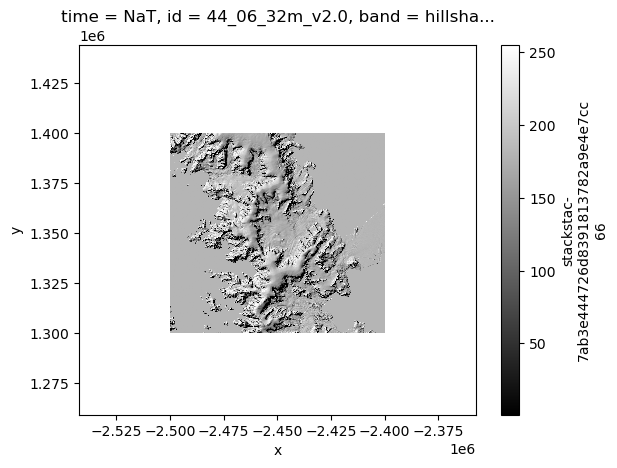

In [94]:
%%time

mosaic_stack.sel(band='hillshade').plot(cmap='gist_gray')

CPU times: total: 2.31 s
Wall time: 4.81 s


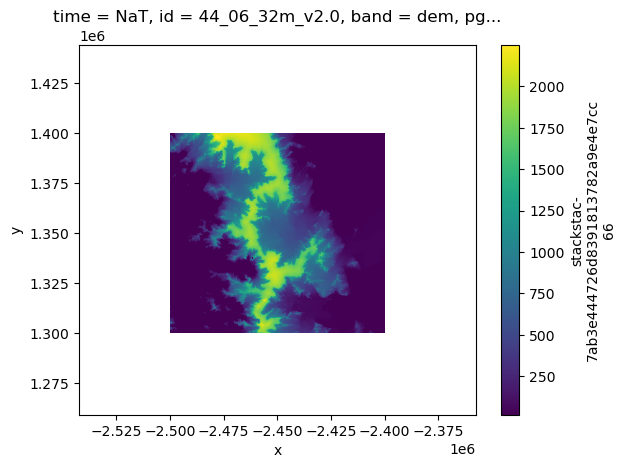

In [95]:
%%time

mosaic_stack.sel(band='dem').plot()